# Postprocessing variables from visdump hdf5 file.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [3]:
import numpy as np

import sys
sys.path.append("/Users/shua784/github/modvis")
import modvis.ATSutils as utils 
import modvis.ats_xdmf as xdmf
import modvis.transect_data as transect_data
import modvis.plot_vis_file as pv
import modvis.general_plots as gp
import modvis.utils as ut 
import modvis.colors as mcolors
import modvis.objectivefunctions as ofs

In [4]:
model_dir = "../data/coalcreek/"

prefix = "ats_vis"
subsurface_mesh = f"{prefix}_mesh.h5"
surface_mesh = f"{prefix}_surface_mesh.h5"
subsurface_h5 = f"{prefix}_data.h5"
surface_h5 = f"{prefix}_surface_data.h5"

fname_subsurface_h5 = model_dir + subsurface_h5
fname_surface_h5 = model_dir + surface_h5
fname_surface_mesh = model_dir + surface_mesh
fname_mesh = model_dir + subsurface_mesh

# import vis data

## import subsurface mesh

In [5]:
sub_vis = xdmf.VisFile(model_dir, filename=subsurface_h5, mesh_filename=subsurface_mesh)

In [6]:
times = sub_vis.times
t = utils.rmLeapDays(times, freq='D')

In [7]:
list(sub_vis.d.keys())

['cell_volume.cell.0',
 'porosity.cell.0',
 'pressure.cell.0',
 'saturation_liquid.cell.0']

In [49]:
# var = "saturation_liquid"
# idat = sub_vis.getArray(var)

In [8]:
sub_vis.loadMesh()

In [9]:
centroids = sub_vis.centroids

centroids.shape

(171760, 3)

In [10]:
etype, coords, conn = xdmf.meshXYZ(model_dir, filename=subsurface_mesh)
etype, len(coords), conn.shape

('PRISM', 92660, (171760, 7))

In [11]:
vertex_xyz = np.array(list(coords.values()))

Reorder 3D meshes to a "structured in z" mesh. Return shape of (ntriangles-per-layer, nlayers, ndim).

In [12]:
ordered_centroids, map = xdmf.structuredOrdering(centroids, columnar=True)
ordered_centroids.shape, map.shape # from bottom to top, ie, z is increasing

((9040, 19, 3), (9040, 19))

## import surface mesh

In [13]:
surface_vis = xdmf.VisFile(model_dir, domain="surface", filename=surface_h5, 
                           mesh_filename=surface_mesh, 
                          )

In [14]:
times = surface_vis.times
t = utils.rmLeapDays(times)

In [15]:
list(surface_vis.d.keys())

['surface-area_fractions.cell.1',
 'surface-cell_volume.cell.0',
 'surface-ponded_depth.cell.0',
 'surface-surface_subsurface_flux.cell.0',
 'surface-total_evapotranspiration.cell.0']

In [16]:
# etype: element type (ie shape of mesh); coords: the xyz coordinates of vertex (shape indicates the # of vertex); 
# conn: the connection of the vertex that forms the triangles. the shape indicates the # of triangles.

surface_etype, surface_coords, surface_conn = xdmf.meshXYZ(model_dir, filename=surface_mesh)
surface_etype, len(surface_coords), surface_conn.shape

('TRIANGLE', 4633, (9040, 4))

In [17]:
surface_vertex_xyz = np.array(list(surface_coords.values()))
# surface_vertex_xy = np.array(list(surface_coords.values()))[:, 0:2]
triangles = surface_conn[:, -3:]

In [18]:
surface_vis.loadMesh()
surface_centroids = surface_vis.centroids
# centroids.shape

area = surface_vis.volume

# plot surface ponded depth

2022-05-12 12:28:23,010 - root - INFO: No unit convertion.


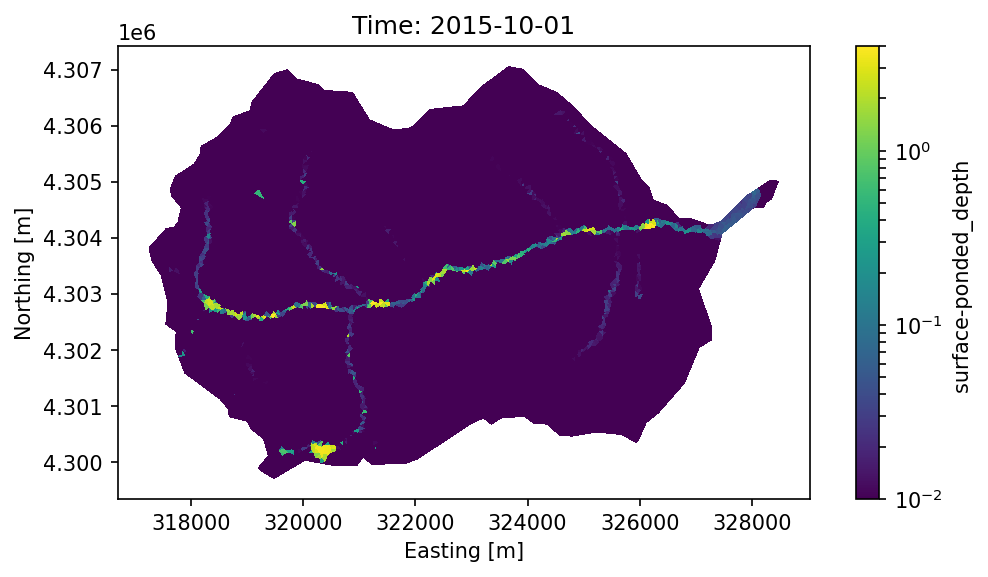

In [27]:
fig, ax, tpc = pv.plot_surface_data(surface_vis, surface_vertex_xyz, surface_conn, 
                               var_name="surface-ponded_depth", log = True,
                                    vmin=0.01, vmax=4, colorbar=True,
                              time_slice=0)

# plot subsurface satuation

## single column

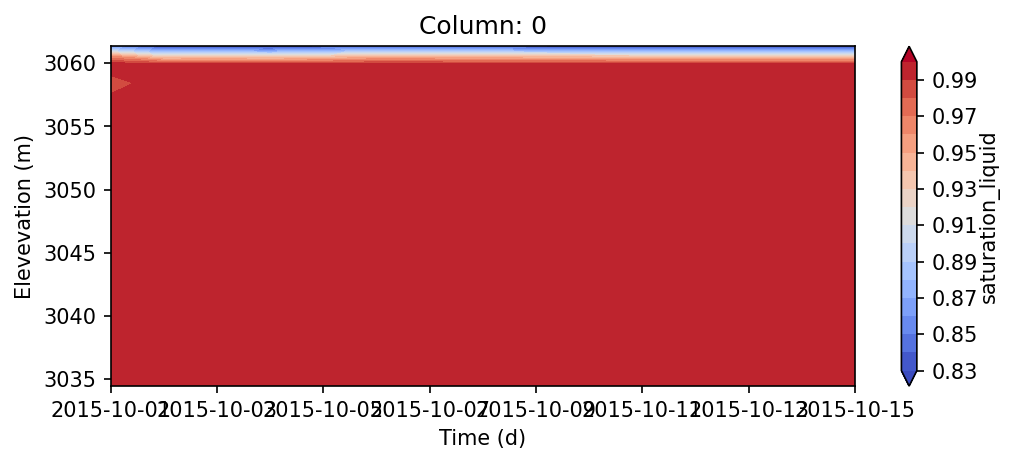

In [28]:
fig, ax = pv.plot_column_data(sub_vis, ordered_centroids, map, "saturation_liquid", cmap = "coolwarm", 
                              col_ind=0)

## single layer

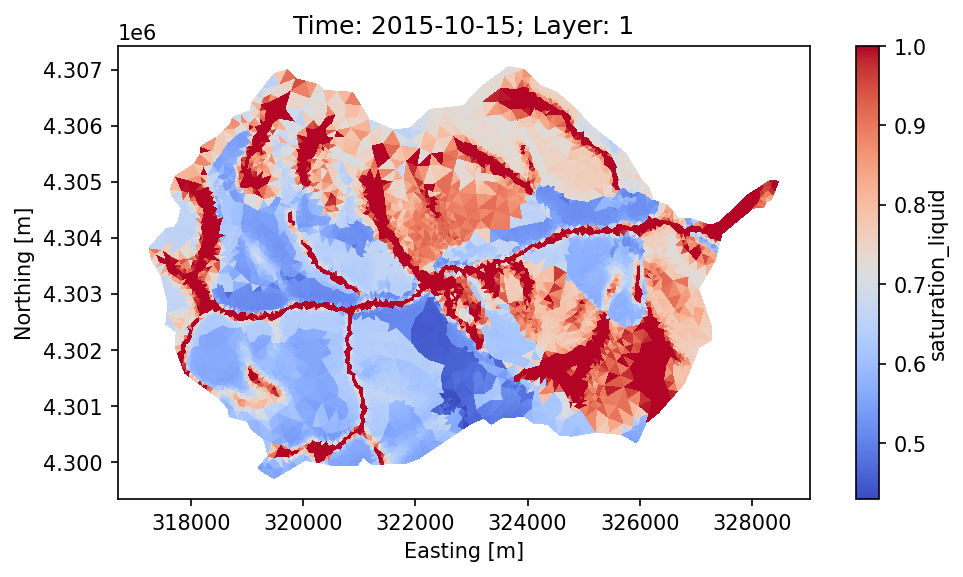

In [29]:
fig, ax = pv.plot_layer_data(sub_vis, ordered_centroids, vertex_xyz, conn, map, 
                          var_name = "saturation_liquid", layer_ind = 0, 
                          cmap = "coolwarm",
                          time_slice=-1)

# plot groundwater table

## single column

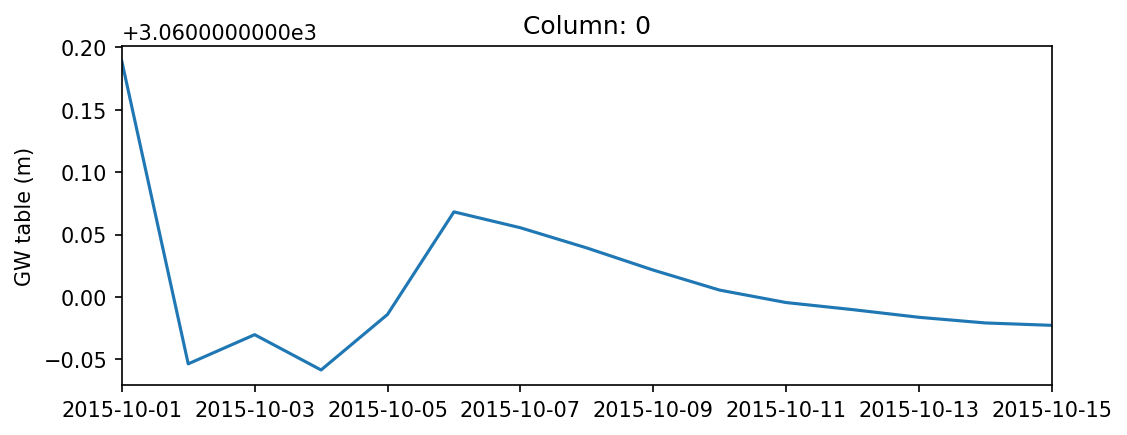

In [31]:
ihead = pv.plot_column_head(sub_vis, ordered_centroids, map, col_ind = 0)

## GW surface

In [32]:
# returned dat has shape((x,z, var), ntime, ntris-"x order", nlayers-"z order")
dat = transect_data.transect_data("pressure", directory = model_dir, filename=subsurface_h5, 
                    mesh_filename=subsurface_mesh)

In [33]:
dat.shape

(3, 15, 9040, 19)

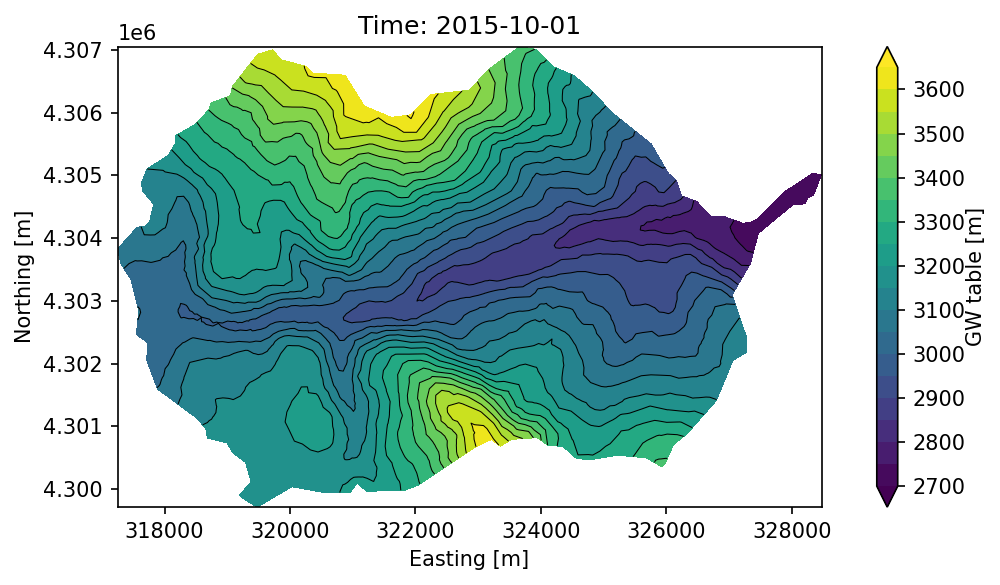

In [35]:
fig, ax, tpc = pv.plot_gw_surface(dat, t, vertex_xyz, conn, map, time_slice = 0, 
                   contour = True, contourline = True, nlevel = np.arange(2700,3665, 50), 
                                  colorbar = True,
                                 )

# plot ET

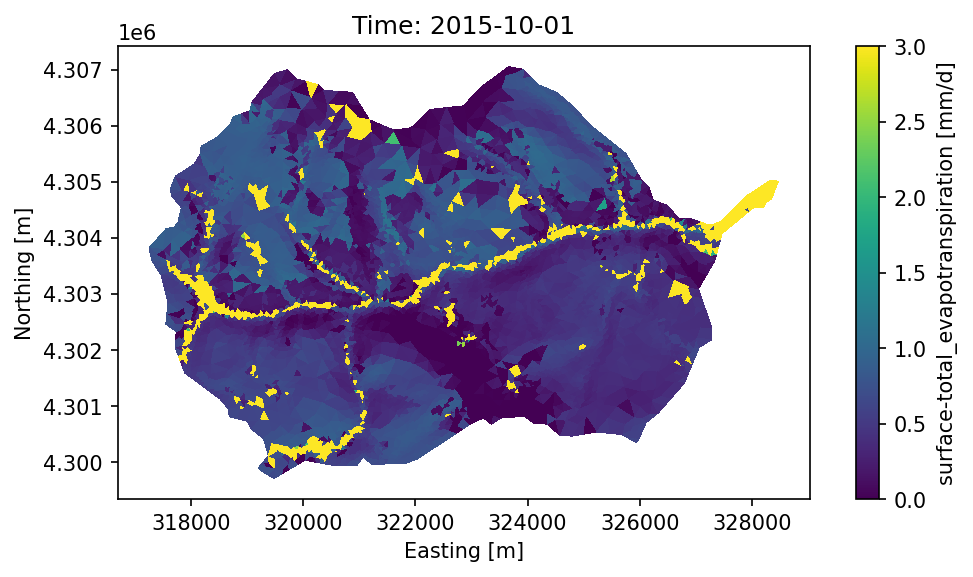

In [40]:
fig, ax, tpc = pv.plot_surface_data(surface_vis, surface_vertex_xyz, surface_conn, 
                               var_name="surface-total_evapotranspiration",
                               title = True, log = False, colorbar = True,
                                    time_slice=0, 
                               vmin=0, vmax=3,
                              )

# plot snow cover

2022-05-12 14:09:29,798 - root - INFO: No unit convertion.


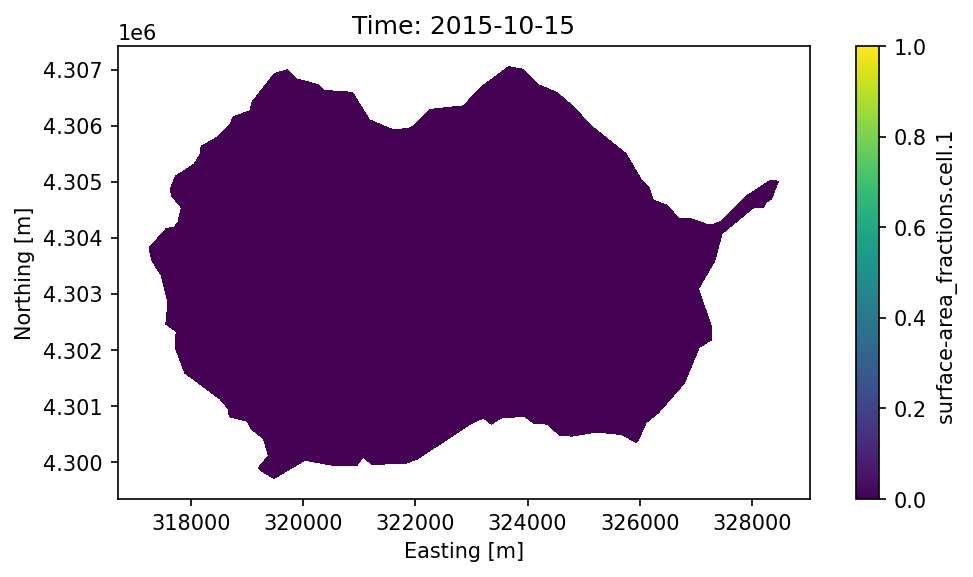

In [44]:
fig, ax, _ = pv.plot_surface_data(surface_vis, surface_vertex_xyz, surface_conn, 
                               var_name="surface-area_fractions.cell.1",
                               title = True, log = False, time_slice=-1, 
                               vmin=0, vmax=1
                              )

# Volumetric water content

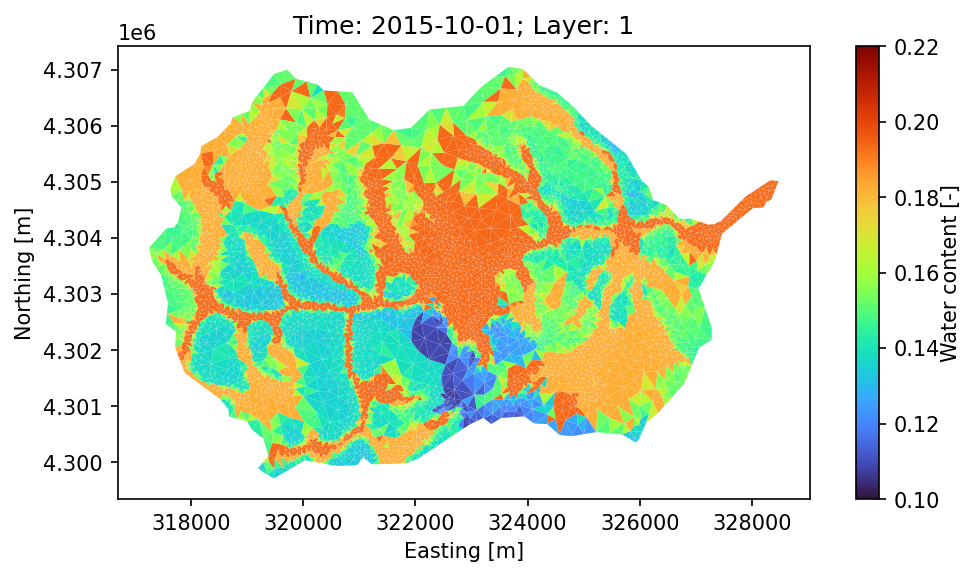

In [20]:
fig, ax, tpc = pv.plot_water_content(sub_vis, ordered_centroids, vertex_xyz, conn, map, 
                          layer_ind = 0, colorbar= True, vmin = 0.1, vmax = 0.22, cmap = 'turbo',
                          time_slice=0)
# cb = plt.colorbar(tpc, extend = "both" )
# cb.ax.set_ylabel("Soil moisture [-]", labelpad=0.3, fontsize = 12)